# T032 · Compound activity: Proteochemometrics

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Marina Gorostiola González, 2022, [Computational Drug Discovery](https://www.universiteitleiden.nl/en/science/drug-research/drug-discovery-and-safety/computational-drug-discovery), Drug Discovery & Safety Leiden University (The Netherlands)
- Olivier J.M. Béquignon, 2022, Computational Drug Discovery, Drug Discovery & Safety Leiden University (The Netherlands)
- Willem Jespers, 2022, Computational Drug Discovery, Drug Discovery & Safety Leiden University (The Netherlands)

## Aim of this talktorial

While activity data is very abundant for some protein targets, there are still a number of underexplored proteins where the use of machine learning (ML) for activity prediction is very difficult due to the lack of data. This issue can be partially solved by leveraging similarities and differences between proteins. In this talktorial, we use proteochemometrics (PCM) modeling to enrich our activity models with protein data to predict the activity of novel compounds against the four [adenosine receptor](https://journals.physiology.org/doi/full/10.1152/physrev.00049.2017) isoforms (A1, A2A, A2B, A3).

### Contents in *Theory*
* Proteochemometrics (PCM) modeling
* Data preparation
    * Papyrus dataset
    * Molecule encoding: molecular descriptors
    * Protein encoding: protein descriptors
* Machine learning principles: regression
    * Data splitting methods
    * Regression evaluation metrics
    * ML algorithm: Random Forest
* Applications of PCM in drug discovery

### Contents in *Practical*

* Download Papyrus dataset
* Data preparation
    * Filter activity data for targets of interest
    * Align target sequences
    * Calculate protein descriptors
    * Calculate compound descriptors
* Proteochemometrics modeling
    * Helper functions
    * Preprocessing
    * Model training and validation
        * Random split PCM model
        * Random split QSAR models
        * Leave one target out split PCM model

### References

* Papyrus scripts [GitHub](https://github.com/OlivierBeq/Papyrus-scripts)
* Papyrus dataset preprint: [*ChemRvix* (2021)](https://chemrxiv.org/engage/chemrxiv/article-details/617aa2467a002162403d71f0)
* Molecular descriptors (Modred): [*J. Cheminf.*, 10, (2018)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)
* Protein descriptors (ProDEC) [GitHub](https://github.com/OlivierBeq/ProDEC)
* Regression metrics [(Scikit learn)](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)
* XGBoost [Documentation](https://xgboost.readthedocs.io/en/stable/index.html)
* Proteochemometrics review: [*Drug Discov.* (2019), **32**, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub)



## Theory

### Proteochemometrics (PCM) modeling

Proteochemometrics (PCM) models a biological endpoint (e.g. compound activity) via supervised ML algorithms based on a series of features derived from chemical compounds and target proteins. PCM is an extension of a more widespread bioactivity modeling technique, Quantitative Structure Activity Relationship (QSAR) modeling, which relies solely on chemical features and that was introduced on **Talktorial T007**. Explore that talktorial to know more about the basic principle of activity prediction using ML.

To successfully apply PCM modeling, we need a large dataset of molecule-protein pairs with known bioactivity values, a way of describing molecules and proteins, and a ML algorithm to train a model. Then, we can make predictions for new molecule-protein pairs.


<img src='images/PCM_model_text-01.png' width="700">

*Figure 1:*
Proteochemometrics modeling construction from protein and molecular descriptors for which protein-compound pair bioactivity data is known.
Figure made by Marina Gorostiola González.

### Data preparation

#### Papyrus dataset

The Papyrus dataset is a highly curated compilation of bioactivity data intended for modeling in drug discovery. Apart from the bioactivity data contained in the [ChEMBL database](https://www.ebi.ac.uk/chembl/) (see also  **Talktorial T001**), the Papyrus dataset contains binary data for classification tasks from the [ExCAPE-DB](https://solr.ideaconsult.net/search/excape/), and bioactivity data from a number of kinase-specific papers (Figure 1). The Papyrus dataset consists of almost 60M compound-protein pairs, representing data of around 1.2M unique compounds and 7K proteins across 499 different organisms.

The aggregated bioactivity data is standardized, repaired, and normalized to form the Papyrus dataset, which is updated with every new version of ChEMBL released. The Papyrus dataset contains "high quality" data associated with pChEMBL values for regression or classification tasks. pChEMBL value is a canonical activity metric defined as $-log_{10}(molar IC_{50}, XC_{50}, EC_{50}, AC_{50}, Ki, Kd, or potency)$. Moreover, "low quality" data that is only associated with an active/inactive label can be used for classification tasks (read more about ML applications in **Talktorial T007**).

<img src='images/papyrus_workflow.png' width="700">

*Figure 2:*
Papyrus dataset generation scheme.
Figure taken from: Papyrus scripts [GitHub](https://github.com/OlivierBeq/Papyrus-scripts).

#### Molecule encoding: molecular descriptors

For the ML models used in PCM, molecules need to be converted into a list of features. In **Talktorial T007**, molecular fingerprints were introduced. In this talktorial, we will use a different type of representation that is often used on its own or in combination with fingerprints: molecular descriptors.

**Molecular descriptors** are the "final result of a logical and mathematical procedure, which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment" ([*J. Cheminf.*, 10, (2018)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)). These descriptors can be, for example, molecular weight, ring count, Eccentric Connectivity Index (calculated from the 2D structure), or Geometrical Index (calculated from the 3D structure).

In this talktorial, we use [Modred](https://github.com/mordred-descriptor/mordred) as a software engine to calculate molecular descriptors. Modred calculates more than 1,800 molecular descriptors, including the ones implemented in RDKit. The algorithm starts with an automatic preprocessing step that is common for all possible descriptors calculated. For simplicity, here we calculate only four types of descriptors from the vast list of possibilities from Modred, excluding their 3D representation. These four descriptors are:

* **ABC Index**: 2 descriptors that represent the atom-bond connectivity index or the Graovac-Ghorbani atom-bond connectivity index (see Modred `ABCIndex` [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.ABCIndex.html))
* **Acid-Base**: 2 descriptors that count acidic and basic groups, respectively (see Modred `AcidBase` [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.AcidBase.html?highlight=acidbase))
* **Atom count**: 16 descriptors that represent a count of different types of atoms (see Modred `AtomCount` [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.AtomCount.html?highlight=atomcount))
* **Balaban J index**: 1 descriptor that represents a topological index (see Modred `BalabanJ` [docs](https://mordred-descriptor.github.io/documentation/master/api/mordred.BalabanJ.html?highlight=balaban#module-mordred.BalabanJ))

#### Protein encoding: protein descriptors

As done for molecules, the proteins of interest need to be converted to a list of features or protein descriptors. Protein descriptors used in PCM applications are commonly based on the protein sequence and represent physicochemical characteristics of the amino acids that make up the sequence (e.g. Z-scales). Other protein descriptors represent topological (e.g. ST-scales) or electrostatic properties (e.g. MS-WHIM) of the protein sequence. Moreover, if structural information is available, protein descriptors can be derived from the 3D structure of the protein (e.g. sPairs) or the ligand-protein interaction in 3D (e.g. interaction fingerprints). Finally, with the widespread use of deep learning, protein embeddings can be obtained after parsing the protein sequence through the network (e.g. UniRep, AlphaFold embeddings). To read more about protein descriptors, check out these selection of articles ([*Brief. Bioinform.*,18, (2017)](https://pubmed.ncbi.nlm.nih.gov/26873661/), [*Int. J. Mol. Sci.*, 22, (2021)](https://pubmed.ncbi.nlm.nih.gov/34884688/), [*Comput. Struct. Biotechnol. J.*, 20, (2022)](https://pubmed.ncbi.nlm.nih.gov/35222841/)).

For protein descriptors based on the protein sequence, an aspect to take into account is that for ML the length of the protein descriptor needs to be the same. However, most proteins do not have the same sequence length. To solve this issue, there are two main approaches:

* **Multiple sequence alignment (MSA)**: If the entire protein is to be included in the model, a MSA can be performed. The final descriptor has as many entries as the number of features per amino acid multiplied by the number of aligned positions. To account for gaps in the alignment, zeros are introduced in the descriptor. A MSA is a tool to identify common patterns between three or more biological sequences, usually DNA, RNA, or protein. One of the most common tools to perform MSA is Clustal Omega (or ClustalO), available as a [webtool](https://www.ebi.ac.uk/Tools/msa/clustalo/).
* **Binding pocket selection**: To avoid unnecessary features, a binding pocket of the same length can be selected for each protein. Normally, the binding pocket selection is preceded by a multiple sequence alignment and driven by known structural or mutagenesis data.

Other options are available when proteins are not of the same family or do not share a binding pocket (see [*Drug Discov.* (2019), **32**, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub))

In this talktorial, we will focus on physicochemical protein descriptors, mainly **Z-scales** ([*J. Med. Chem*, 30 (1987)](https://pubs.acs.org/doi/10.1021/jm00390a003)). The Z-scales descriptor assigns three pre-determined values (Z~1~, Z~2~, Z~3~) to each amino acid in the sequence. The Z~1~, Z~2~, and Z~3~ values are the first principal components of a principal component analysis (PCA) including 29 different physicochemical variables to characterize the amino acids.
Since we are calculating activity for four proteins with very high sequence similarity (Adenosine receptors A1, A2A, A2B, and A3), we will use **multiple sequence alignment** prior to calculation of the Z-scales. To calculate Z-scales we will use [ProDEC](https://github.com/OlivierBeq/ProDEC), an open source resource that compiles a large number of protein descriptors.

### Machine learning principles: regression

The ML principles for PCM modeling are equivalent to those explained for QSAR modeling. However, in this talktorial we will explore a supervised ML application other than classification, this is **regression**. For regression tasks, a continuous target variable is needed, for example pChEMBL values.

**Note**: Target variable is the variable we want to predict in ML. Not to be confused with (protein) target.

#### Data splitting methods

Similarly to classification tasks, in supervised ML regression applications the model is first fitted to a training set and subsequently the predictive performance is evaluated on a test set. Therefore, the original dataset needs to be split between training and test sets. The split needs to ensure that the fitting process has enough data, and that the test set is representative. Normally, the distribution between train and test set is 80/20 or 70/30. Depending on the applicability domain, the split can be done in multiple ways. In PCM modeling, some of the most common splitting methods are:

* **Random split**: This method is not particularly relevant in drug discovery applications as it does not reflect the reality of a drug discovery campaign and it will most likely lead to data leaks between the training and test set. This is, very similar data will be found in both sets, which will lead to an overestimation of the predictive performance of the model. This type of split is commonly used, however, as a baseline and point of reference for other splitting methods, or as a starting point for quick model comparisons.
* **Leave one target out (LOTO) split**: To evaluate the ability of the model to extrapolate to targets not previously seen, one of the targets can be completely moved to the test set. In a big enough set, instead of one "some" targets can be moved to the test set (i.e. Leave some targets out, or LSTO).
* **Leave one compound cluster out (LOCCO) split**: This method evaluates the ability of the model to extrapolate to compounds with properties not previously seen by the model. Clustering can be done based on different molecular characteristics, such as physicochemical properties or scaffold, for example (see **Talktorial T005** to learn more about clustering). One (or several, LSCCO) cluster(s) can then be left out for testing. This method prevents data leaking in terms of chemistry between training and test sets.
* **Temporal split**: This method was developed in order to account for the usual timeline of drug discovery campaigns, where chemical series are populated sequentially over time. In this approach, the molecules included in the training set are those released until a certain date and the rest (most novel) are included in the test set.
* **Stratified split per target**: This method can be applied to any of the splitting methods described above (except LOTO), and aims to include data of all targets in both the training and test set, so that additional target-compound interactions can be extracted by the model. (**NOTE:** stratification can be also done in regards to other reference points apart from targets, for example classes in classification tasks, to make sure that the distribution is similar across training and test set).

<img src='images/splitting_methods.png' width="700">

*Figure 3:*
Overview of splitting methods, including target-stratified random and temporal splits and leave one target out approach.
Figure made by Marina Gorostiola González.

#### Regression evaluation metrics


To evaluate the predictive performance of a regression model, there are several metrics that in simple terms measure the differences between the true target values and the predictions made by the model. These metrics can be used in cross-validation on the training set (see **Talktorial T007**) or in the test set. The most commonly used metrics include:

* **Coefficient of determination (**$R^{2}$ **score)**: Represents the portion of variance of the target variable that has been explained by the independent variables (features) in the model. $R^{2}$ score varies between 1.0 (best score) and minus infinite, where 0.0 represents a model that always predicts the average target variable. As the variance is dataset-dependent, it might not be a meaningful metric to compare between datasets. When dealing with linear regression, and model fitting and evaluation are performed on a single dataset, $R^{2}$ is equivalent to the square of the Pearson correlation coefficient, described below, and can be noted as $r^{2}$.
* **Pearson's correlation coefficient (Pearson's** $r$**)**: Is a measure of the linear correlation between the true and predicted values of the target variable. It is calculated as the covariance of the two variables divided by the product of their standard deviation. Pearson's $r$ can vary between 1.0 (a perfect positive correlation) and -1.0 (a perfect negative correlation), where 1.0 would represent a perfect prediction.
* **Mean absolute error (MAE)**: Measures the average absolute difference between the predicted and the true values. MAE is interpreted based on the scale of the data, and it varies between infinite and 0.0 (best).
* **Mean squared error (MSE)**: Measures the average of the squares of the difference between the predicted and the true values. It varies between infinite and 0.0 (best).
* **Root mean square error (RMSE)**: It is the square root of the MSE and represents the standard deviation of the prediction errors with respect to the line of best fit. RMSE is a measure of accuracy and it cannot be applied to compare  between datasets, as it is scale-dependent. It varies between infinite and 0.0 (best).

To learn more about evaluation metrics, you can consult scikit learn's `regression metrics` [Docs](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

#### ML algorithm: Random Forest

Different ML algorithms can be used to train PCM models. Some of them include support vector machines (SVM), **random forest (RF)**, and neural networks (NN), which were described in **Talktorial T007**. RF models have been used extensively in PCM applications due to their efficiency in large datasets and resistance to overfitting with more features. However, deep learning applications are also gaining momentum. See [*J. Cheminform.*, 45, (2017)](https://pubmed.ncbi.nlm.nih.gov/29086168/) for a comparative use of ML methods in PCM modeling.
In this talktorial, we will use RF. RF is a decision tree-based algorithm, more in detail a bagging ensemble method. This means that there are multiple decision trees trained independently with subsets of features and data and the final prediction is made from a consensus between the independent predictions.


### Applications of PCM in drug discovery

The possibility to predict bioactivity for multiple targets in one model with PCM is very interesting in drug discovery and expands the applicability domain of QSAR modeling. Some applications of this technique are listed below and help answer the following questions in drug discovery:

* **Poly-pharmacology**: Is it possible to target several proteins of interest simultaneously with one single drug?
* **Off-target prediction**: What other proteins do these compounds target apart from the intended therapeutic target? Are maybe these off-targets responsible for side effects?
* **Selectivity prediction**: Do certain novel compounds target one protein isoform while avoiding others (off-targets) known to cause adverse effects?

To know more about applications of PCM in drug discovery, have a look at this review [*Drug Discov.* (2019), **32**, 89-98](https://www.sciencedirect.com/science/article/pii/S1740674920300111?via%3Dihub).

## Practical

In the practical section of this talktorial we will create a PCM regression model for the four adenosine receptors (A1, A2A, A2B, A3) with data from the Papyrus dataset and molecular and protein descriptors as features.

Before we start, let's install a few packages that are not part of TeachOpenCADD's [global enviroment file](https://github.com/volkamerlab/teachopencadd/blob/master/devtools/test_env.yml) because they are only relevant to this notebook (this setup will change in the future, see discussion [here](https://github.com/volkamerlab/teachopencadd/discussions/277)).

In [ ]:
!pip install prodec rich-msa xmltramp2

In [ ]:
!pip install git+https://github.com/OlivierBeq/Papyrus-scripts.git

In [4]:
import json
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
import Bio
import Bio.SeqIO as Bio_SeqIO
from rdkit import Chem
import rich
import rich_msa
import papyrus_scripts
import mordred
import mordred.descriptors as mordred_descriptors
import prodec

In [5]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

**Note**: We will lateron use the ClustalO web service to align multiple sequences. In order to use the service, we need to provide an email address (see the [docs](https://www.ebi.ac.uk/seqdb/confluence/display/JDSAT/Clustal+Omega+Help+and+Documentation)).
Please set your email address here; for the purpose of this template talktorial, we set the email to `None` and use pre-calculated data (see "Practical" section of this talktoria and [this discussion](https://github.com/volkamerlab/teachopencadd/discussions/283)).

In [6]:
# Set your email for the ClustalO service
# Replace None with your email address
MY_EMAIL = None

### Download Papyrus dataset

To work with the Papyrus dataset, we use the `papyrus_scripts` [library](https://github.com/OlivierBeq/Papyrus-scripts). This library allows us to download, read, and explore the dataset. Many other features, including bioactivity modeling, are possible using the `papyrus_scripts`. If you want to dive into them, feel free to follow the [notebook with simple examples](https://github.com/OlivierBeq/Papyrus-scripts/blob/master/notebook_examples/simple_examples.ipynb). By default, the `download_papyrus` function retrieves bioactivity, target and other information for the latest version of the Papyrus dataset. The data retrieved consists of the highest quality continuous bioactivity data (Papyrus++) without stereochemistry annotated (i.e. `nostereo=True` and `stereo=False`). Check out the [documentation](https://github.com/OlivierBeq/Papyrus-scripts/blob/master/src/papyrus_scripts/download.py) to learn more about the options available.

In [7]:
# Let's specify the Papyrus version for the rest of the work
PAPYRUS_VERSION = "05.5"

In [8]:
%%time
papyrus_scripts.download_papyrus(
    outdir=DATA, version=PAPYRUS_VERSION, nostereo=True, stereo=False, descriptors=None
)
# If you want to download the latest version of the Papyrus dataset, change 'PAPYRUS_VERSION' to 'latest'

Number of files to be donwloaded: 6
Total size: 118MB


Donwloading version 05.5:   0%|          | 0.00/118M [00:00<?, ?B/s]

CPU times: user 1.86 s, sys: 829 ms, total: 2.69 s
Wall time: 57.3 s


### Data preparation

#### Filter activity data for targets of interest

From the Papyrus dataset, we want to extract continuous activity data for all compound-protein pairs for the four human Adenosine receptors; unique compound-target activity values are reported by aggregating data from different assays available. To account for the different types of bioactivity units available, a canonical activity metric defined by ChEMBL is used, pChEMBL value. From the activity aggregation strategies available with the Papyrus set, we will use the Mean (`pchembl_value_Mean` variable).

|Receptor|UniProt accession|
|---|---|
|A1|P30542|
|A2A|P29274|
|A2B|P29275|
|A3|P0DMS8|

In [9]:
def filter_explore_activity_data(papyrus_version, targets):
    """
    Filter Papyrus dataset for targets of interest and explore the statistics of the resulting dataset

    Parameters
    ----------
    papyrus_version : str
        Version of the Papyrus dataset to read
    targets : dict
        Dictionary with target labels as keys and UniProt accession codes as values

    Returns
    -------
    pandas.DataFrame
        Filtered bioactivity dataset for input targets
    """
    # Read downloaded Papyrus dataset in chunks, as it does not fit in memory
    CHUNKSIZE = 100000
    data = papyrus_scripts.read_papyrus(
        version=papyrus_version, chunksize=CHUNKSIZE, source_path=DATA
    )

    # Create filter for targets of interest
    target_accession_list = targets.values()
    filter = papyrus_scripts.keep_accession(data, target_accession_list)

    # Iterate through chunks and apply the filter defined
    filtered_data = papyrus_scripts.preprocess.consume_chunks(
        filter,
        total=-(
            -papyrus_scripts.utils.IO.get_num_rows_in_file("bioactivities", False) // CHUNKSIZE
        ),
    )
    # Add column named 'Target' for easier data visualization
    filtered_data["Target"] = filtered_data["accession"].apply(
        lambda x: [i for i in targets.keys() if targets[i] == x][0]
    )

    # Print number of bioactivity datapoints per target
    print("Number of bioactivity datapoints")
    for target, accession in zip(targets.keys(), targets.values()):
        print(
            f'{target} ({accession}) : {filtered_data[filtered_data["accession"]==accession].shape[0]}'
        )

    # Plot distribution of activity values (pchembl_value_Mean) per target
    g = sns.displot(
        filtered_data,
        x="pchembl_value_Mean",
        hue="Target",
        element="step",
        hue_order=targets.keys(),
    )

    return filtered_data

  0%|          | 0/13 [00:00<?, ?it/s]

Number of bioactivity datapoints
A1 (P30542) : 3519
A2A (P29274) : 3991
A2B (P29275) : 1988
A3 (P0DMS8) : 3221


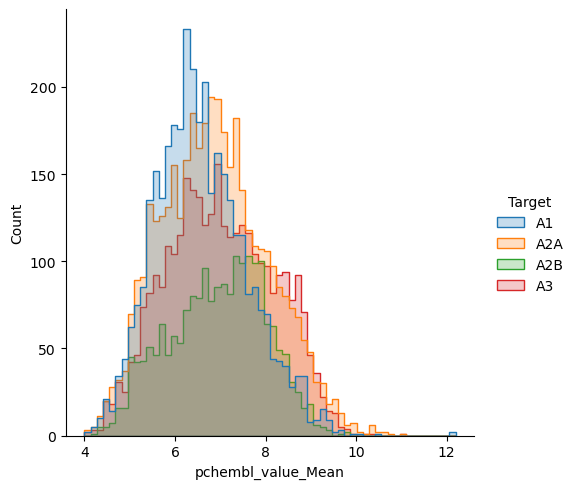

In [10]:
# Define the set of receptors of interest with a label and their UniProt accession
adenosine_receptors = {"A1": "P30542", "A2A": "P29274", "A2B": "P29275", "A3": "P0DMS8"}

# Filter the Papyrus bioactivity dataset and plot the distribution of activity values for the targets of interest
ar_dataset = filter_explore_activity_data(PAPYRUS_VERSION, adenosine_receptors)

For PCM modeling, we keep from our bioactivity dataset three variables:

* Bioactivity (`pchembl_value_mean`), which is our target variable to predict
* Target IDs (`accession`), which is the UniProt code to link the protein descriptors that we will calculate with ProDEC
* Compound IDs (`SMILES`), to link the compound descriptors that we will calculate with Mordred

In [11]:
ar_dataset = ar_dataset[["SMILES", "accession", "pchembl_value_Mean"]]
ar_dataset.head()

,SMILES,accession,pchembl_value_Mean
222,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P29274,8.6800
223,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P30542,6.6800
383,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,P29274,4.8200
462,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P0DMS8,7.1515
464,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P29274,5.6500


#### Align target sequences

In order to ensure protein descriptors are of the same length, we first need to align the target sequences. We do this by creating a MSA with the software Clustal Omega (ClustalO). To begin with, we extract the protein sequences from the target files in Papyrus. The sequences could also be obtained from UniProt, but this way we ensure we are always retrieving the canonical isoform sequence.
Since Papyrus also contains bioactivity data for different mutants and species, the main protein identifier (`target_id` variable) consists of the UniProt accession code and the mutant ('WT' for wild type). Even though we are interested in the wild type, to map our targets of interest we calculate a new variable called `accession` to be consistent with the rest of the talktorial.

In [12]:
protein_data = papyrus_scripts.read_protein_set(version=PAPYRUS_VERSION)
# Create new variable 'accession' with the UniProt accession codes by splitting target_id and keeping the first part
protein_data["accession"] = protein_data["target_id"].apply(lambda x: x.split("_")[0])
# Filter protein data for our targets of interest based on accession code
targets = protein_data[protein_data.accession.isin(adenosine_receptors.values())]
targets

,target_id,HGNC_symbol,UniProtID,Status,Organism,Classification,Length,Sequence,accession
47,P29275_WT,ADORA2B,AA2BR_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,332,MLLETQDALYVALELVIAALSVAGNVLVCAAVGTANTLQTPTNYFL...,P29275
80,P30542_WT,ADORA1,AA1R_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,326,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,P30542
81,P29274_WT,ADORA2A,AA2AR_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,412,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,P29274
82,P0DMS8_WT,ADORA3,AA3R_HUMAN,reviewed,Homo sapiens (Human),Membrane receptor->Family A G protein-coupled ...,318,MPNNSTALSLANVTYITMEIFIGLCAIVGNVLVICVVKLNPSLQTT...,P0DMS8


In order to align the sequences with ClustalO, we first need to write them into a FASTA file.

In [13]:
# Create object with sequences and descriptions
records = []
for index, row in targets.reset_index(drop=True).iterrows():
    records.append(
        Bio_SeqIO.SeqRecord(
            seq=Bio.Seq.Seq(row["Sequence"]),
            id=str(index),
            name=row["accession"],
            description=" ".join([row["UniProtID"], row["Organism"], row["Classification"]]),
        )
    )
sequences_path = Path(DATA / "sequences.fasta")
# Write sequences as .fasta file
_ = Bio_SeqIO.write(records, sequences_path, "fasta")

Now, we use ClustalO to align the sequences and write out the alignment file. We do this by calling the ClustalO webservice from the command line.

In [14]:
def align(entry_name):
    """
    From the GPCRdb, get protein annotations associated with the input UniProt entry name.

    Parameters
    ----------
    entry_name : str
        UniProt entry name for GPCR of interest.

    Returns
    -------
    dict
        Protein annotations deposited in the GPCRdb.
    """

    url = f"https://www.ebi.ac.uk/Tools/common/tools/help/index.html?tool=clustalo#!/Submit32job/post_run"
    url = f"https://gpcrdb.org/services/protein/{entry_name}/"
    response = requests.get(url)
    data = response.json()
    return data

<div class="alert alert-block alert-info">

If you are running this notebook on your own data, please set your email address in the `MY_EMAIL` variable.

</div>

In [15]:
%%bash -s "$MY_EMAIL"
# ClustalO service requires an email address
# If email was set, run ClustalO service, else use pre-calculated alignments
if [ $1 != "None" ]; then
    echo "Email (MY_EMAIL) was set to "$1
    # Query ClustalO webservice from command line
    python scripts/clustalo.py --email $1 --stype protein --sequence data/sequences.fasta --outfmt fa --outdir data --outfile aligned_sequences --order input --pollFreq 20
else
    echo "Email (MY_EMAIL) was not set; use pre-calculated alignments."
fi

Email (MY_EMAIL) was not set; use pre-calculated alignments.


Finally we parse the aligned sequences.

In [16]:
alignment_file = Path(DATA / "aligned_sequences.aln-fasta.fasta")
aligned_sequences = [str(seq.seq) for seq in Bio.SeqIO.parse(alignment_file, "fasta")]

And we visualize the MSA.

In [17]:
# Read MSA
msa = Bio.AlignIO.read(alignment_file, "fasta")
viewer = rich_msa.RichAlignment(
    names=[record.description for record in msa],
    sequences=[str(record.seq) for record in msa],
)
# Visualize MSA
panel = rich.panel.Panel(viewer, title="Multiple sequence alignment")
rich.print(panel)

╭────────────────────────────────────────── Multiple sequence alignment ──────────────────────────────────────────╮
│ 0 AA2BR_H…     1  -----MLLETQDALYVALELVIAALSVAGNVLVCAAVGTANTLQTPTNYFLVSLAAADVAVGLFAIPFAITISLGFCTDFYGCLFLACFVLV  │
│ 1 AA1R_HU…     1  ---MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFCFIVSLAVADVAVGALVIPLAILINIGPQTYFHTCLMVACPVLI  │
│ 2 AA2AR_H…     1  ------MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLV  │
│ 3 AA3R_HU…     1  MPNNSTALSLANVTYITMEIFIGLCAIVGNVLVICVVKLNPSLQTTTFYFIVSLALADIAVGVLVMPLAIVVSLGITIHFYSCLFMTCLLLI  │
│                                                                                                                 │
│ 0 AA2BR_H…    88  LTQSSIFSLLAVAVDRYLAICVPLRYKSLVTGTRARGVIAVLWVLAFGIGLTPFLGWNSKDSATNNCTEPWDGTTNESCC---LVKCLFENV  │
│ 1 AA1R_HU…    90  LTQSSILALLAIAVDRYLRVKIPLRYKMVVTPRRAAVAIAGCWILSFVVGLTPMFGWNNLSAVER----AWA---ANGSMGEPVIKCEFEKV  │
│ 2 AA2AR_H…    87  LTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNN-------CGQPKEGKNHSQGCGEGQVACLFEDV  │
│ 3 AA3R_HU…    93  FTHASIMSLLAIAVDRYLRVKLTVRYKRVTTHRRIWLALGLCWLVSFLVGLTPMFGWNMKLTSEYH-------------RNVTFLSCQFVSV  │
│                                                                                                                 │
│ 0 AA2BR_H…   177  VPMSYMVYFNFFGCVLPPLLIMLVIYIKIFLVACRQLQRTEL----MDHSRTTLQREIHAAKSLAMIVGIFALCWLPVHAVNCVTLFQPAQG  │
│ 1 AA1R_HU…   175  ISMEYMVYFNFFVWVLPPLLLMVLIYLEVFYLIRKQLNKKVSAS--SGDPQKYYGKELKIAKSLALILFLFALSWLPLHILNCITLFCPSC-  │
│ 2 AA2AR_H…   172  VPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDC-  │
│ 3 AA3R_HU…   172  MRMDYMVYFSFLTWIFIPLVVMCAIYLDIFYIIRNKLSLNLSN---SKETGAFYGREFKTAKSLFLVLFLFALSWLPLSIINCIIYFNG---  │
│                                                                                                                 │
│ 0 AA2BR_H…   265  KNKPKWAMNMAILLSHANSVVNPIVYAYRNRDFRYTFHKIISRYLLCQADVKSGNGQ----------AGVQPALGVGL--[1;38;

In the MSA we can observe that the adenosine A2A receptor has a longer C terminus than the rest of the adenosine receptors. Moreover, there are clear parts of the proteins that are very similar in all the receptors (i.e. transmembrane domains), and parts that vary in amino acid composition and length between receptors (i.e. mostly loops).

####  Calculate protein descriptors

Now that our protein sequences are aligned, we can calculate protein descriptors using ProDEC. For that, let's parse all default descriptors available. Since we are focusing on Z-scale descriptors in this talktorial, we can explore the details about this descriptor, and in case we want some extra information we can look at the article where it is first described.

In [18]:
# Parse ProDEC descriptors
desc_factory = prodec.ProteinDescriptors()
# Print available descriptors
print(f"Available ProDEC descriptors: {desc_factory.available_descriptors}")

Available ProDEC descriptors: ['ADFQ', 'BLOSUM', 'c-scales', 'CBFQ', 'CDFQ', 'Combined descriptors', 'Contact energies', 'CUFQ', 'DPPS', 'E-scale', 'FASGAI', 'G-scales', 'GH-scale', 'GRID tscore', 'HESH', 'HPI', 'HSEHPCSV', 'Independent descriptors', 'ISA-ECI', 'Kidera', 'MS-WHIM', 'P-scale', 'PhysChem', 'ProtFP hash', 'ProtFP PCA', 'PSM', 'QCP', 'Raychaudhury', 'Sneath', 'SSIA AM1', 'SSIA DFT', 'SSIA HF', 'SSIA PM3', 'STscale', 'SVEEVA', 'SVGER', 'SVHEHS', 'SVMW', 'SVRDF', 'SVRG', 'SVWG', 'SZOTT', 'Tscale', 'V-scale', 'VARIMAX', 'VHSE', 'VHSEH', 'VSGETAWAY', 'VSTPV', 'VSTV', 'VSW', 'VTSA', 'Zscale binary', 'Zscale Hellberg', 'Zscale Jonsson', 'Zscale Sandberg', 'Zscale Sjöström', 'Zscale van Westen']


In [19]:
# Print information about Z-scales
print("More about Z-Scales:")
desc_factory.get_descriptor("Zscale Hellberg").Info

More about Z-Scales:


{'Authors': 'Hellberg, Sjöström, Skagerberg, Wold',
 'Year': 1987,
 'Journal': 'Journal of Medicinal Chemistry',
 'DOI': '10.1021/jm00390a003',
 'PMID': None,
 'Patent': None}

In [20]:
def calculate_protein_descriptor(targets, aligned_sequences, protein_descriptor):
    """
    Calculate protein descriptor of choice for aligned proteins of interest

    Parameters
    ----------
    targets : pandas.DataFrame
        Pandas dataframe with information about targets of interest
    aligned_sequences : list
        List of aligned sequences read from fasta file produced with Clustal Omega
    protein_descriptor : str
        Protein descriptor label as described in ProDEC

    Returns
    -------
    pandas.DataFrame
        Dataset with accession and features for the protein descriptor of interest for the targets in the input
    """
    # Get protein descriptor from ProDEC
    prodec_descriptor = desc_factory.get_descriptor(protein_descriptor)

    # Calculate descriptor features for aligned sequences of interest
    protein_features = prodec_descriptor.pandas_get(aligned_sequences)

    # Insert protein labels in the obtained features
    protein_features.insert(0, "accession", targets.accession.reset_index(drop=True))

    return protein_features

In [21]:
protein_features = calculate_protein_descriptor(targets, aligned_sequences, "Zscale Hellberg")
protein_features

  0%|          | 0/4 [00:00<?, ?it/s]

,accession,Zscale_1,Zscale_2,Zscale_3,Zscale_4,Zscale_5,Zscale_6,Zscale_7,Zscale_8,Zscale_9,...,Zscale_1269,Zscale_1270,Zscale_1271,Zscale_1272,Zscale_1273,Zscale_1274,Zscale_1275,Zscale_1276,Zscale_1277,Zscale_1278
0,P29275,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,P30542,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,P29274,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.09,2.23,-5.36,0.3,-2.69,-2.53,-1.29,1.96,-1.63,0.57
3,P0DMS8,-2.49,-0.27,-0.41,-1.22,0.88,2.23,3.22,1.45,0.84,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


#### Calculate compound descriptors

The final step to prepare our dataset for PCM is to calculate compound descriptors. For this, we first have to convert the molecules in our dataset to chemical entities from their text representation (SMILES). Afterwards, we use Mordred to calculate 2D molecular descriptors.

In [22]:
def calculate_molecular_descriptors(bioactivity_dataset, user_descriptors):
    """
    Calculate compound molecular descriptors of choice for unique molecules in the bioactivity dataset

    Parameters
    ----------
    bioactivity_dataset : pandas.DataFrame
        Pandas dataframe with bioactivity dataset for PCM
    user_descriptors : list
        List of descriptors from Mordred to calculate
        Use ['all'] for calculate all possible descriptors

    Returns
    -------
    pandas.DataFrame
        Dataset with SMILES and features for the compound descriptors of interest for molecules in the bioactivity dataset
    """
    # Extract unique molecules from the bioactivity dataset
    molecules = [Chem.MolFromSmiles(x) for x in bioactivity_dataset["SMILES"].unique()]

    # Use Mordred to calculate molecular descriptors of interest
    if user_descriptors == ["all"]:
        mordred_calculator = mordred.Calculator(mordred.descriptors, ignore_3D=True)
        molecular_descriptor = mordred_calculator.pandas(molecules, pynb=False)

    else:
        mordred_list = [
            mordred_descriptors.__dict__[descriptor] for descriptor in user_descriptors
        ]
        mordred_calculator = mordred.Calculator(mordred_list, ignore_3D=True)
        molecular_descriptor = mordred_calculator.pandas(molecules, ipynb=False)

    # Clean descriptors step 1: replace mordred format to pandas format
    molecular_descriptor = pd.DataFrame(molecular_descriptor.fill_missing(np.NAN))

    # Clean descriptors step 2: replace ambiguous names (relevant for writing and reading to/from a file)
    mordred_descs_names = {}
    for desc_name in mordred_calculator.descriptors:
        # First we replace the ambiguous names with aliphatic rings
        mordred_descs_names[str(desc_name)] = re.sub(
            r"(.*F?)A(H?Ring)$", r"\1aliph\2", str(desc_name)
        )
        # Then we replace the ambiguous names with aromatic rings
        mordred_descs_names[str(desc_name)] = re.sub(
            r"(.*F?)a(H?Ring)$", r"\1arom\2", mordred_descs_names[str(desc_name)]
        )

    molecular_descriptor = molecular_descriptor.rename(mordred_descs_names)

    # Clean descriptors step 3: remove absurdly big and small values (e.g. topological indexes of molecules containing fragments)
    molecular_descriptor = molecular_descriptor.astype(np.float32).replace(
        [np.inf, -np.inf], np.NAN
    )
    molecular_descriptor = molecular_descriptor.fillna(value=0)

    # Clean descriptors step 4: round values to 3 decimals to reduce memory footprint
    molecular_descriptor = molecular_descriptor.astype(float).round(3)
    molecular_descriptor = molecular_descriptor.convert_dtypes()

    # Insert SMILES in first column for mapping
    molecular_descriptor.insert(0, "SMILES", bioactivity_dataset.SMILES.unique())

    return molecular_descriptor

In [23]:
molecular_features = calculate_molecular_descriptors(
    ar_dataset, ["ABCIndex", "AcidBase", "AtomCount", "BalabanJ"]
)
molecular_features.head()

100%|██████████████████████████████████████| 6898/6898 [00:09<00:00, 741.92it/s]


,SMILES,ABC,ABCGG,nAcid,nBase,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,...,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,BalabanJ
0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,21.041,17.684,0,1,51,27,0,0,8,...,6,2,0,0,0,0,0,0,0,1.631
1,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,20.701,15.635,0,0,42,26,0,0,8,...,4,3,1,0,0,0,0,0,0,1.307
2,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,23.23,17.456,0,0,43,29,0,0,8,...,6,2,0,0,0,0,0,0,0,1.328
3,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,31.336,22.213,0,0,66,40,0,0,14,...,7,6,0,0,0,1,0,0,1,1.043
4,NC(=NC(=O)Cn1c(O)c2CCCCc2c1O)Nc1nc2c(cccc2)s1,21.408,17.066,0,3,46,27,0,0,9,...,5,3,1,0,0,0,0,0,0,1.234


### Proteochemometrics modeling

When our dataset is complete with all the descriptors for proteins and compounds, we can start with the modeling part. Here, we will use a Random Forest (RF) ML regression model to predict the bioactivity of our compound-target pairs.

We will try two methods to split our dataset between training and test set:

* Random split
* Leave one target out (LOTO) split

Additionally, we will compare our PCM model to four independent models trained only on compound data (QSAR), and finally we will comment on the results.

Ultimately, we want a model that can predict compound activity data towards a target of interest for compound-target pairs that it has never seen before. By combining several targets in one model, we expect the model to be able to learn the similarities and differences between targets and use the additional data to make better predictions.

We start by defining a few functions that will help us split the data (`split_train_test`) and train and validate a PCM regression model (`train_validate_pcm_model`). The validation will be done on the test set and the performance will be assessed using regression metrics such as Person's $r$, $R^{2}$ and $MAE$. This function will also plot the correlation between true and predicted values, making a distinction between the different targets in the test set to assess whether the PCM model has a different performance per protein. Finally, we will define a function (`train_validate_qsar_model`) to train a QSAR model for a single target based on a random split. The output of this function will be comparable to that of the PCM model for comparison purposes.

#### Helper functions

Function to split the data using one of these two methods described in theory: random split or leave one target out (LOTO) split.

In [24]:
def split_train_test(
    pcm_dataset, test_size, split_method, loto_target=None, loto_accession="None"
):
    """
    Split a dataset for PCM modeling in train and test set based on the split method of choice

    Parameters
    ----------
    pcm_dataset : pandas.DataFrame
        Pandas dataframe with bioactivity dataset for PCM including compound and protein descriptors
    test_size : float
        Ratio of the data to include in the test set
    split_method : str
        'random' for random split
        'loto' for leave one target out split
    loto_target : str
        Target label to leave out for testing in 'loto' split method
    loto_accession : str
        Target UniProt accession to leave out for testing in 'loto' split method

    Returns
    -------
    train: pandas.DataFrame
        Training dataset
    test : pandas.DataFrame
        Testing dataset
    """
    # Random split
    if split_method == "random":
        train, test = train_test_split(pcm_dataset, test_size=test_size, random_state=1234)

    # Leave one target out
    elif split_method == "loto":
        if loto_accession != None:
            # Leave out defined accession
            test_target = loto_accession
            print(f"Target left out for testing is {loto_target}")
        else:
            raise ValueError("loto_accession needs to be defined")

        # Move data associated with target to test set and rest to training set
        train = pcm_dataset[pcm_dataset["accession"] != test_target]
        test = pcm_dataset[pcm_dataset["accession"] == test_target]

    else:
        raise ValueError(f"Split method {split_method} undefined; use random or loto.")

    # Print statistics of training and test sets
    print(f"Training set has {train.shape[0]} datapoints")
    print(
        f"Test set has {test.shape[0]} datapoints ({round(100*test.shape[0]/pcm_dataset.shape[0], 3)} %)"
    )

    return train, test

Function to report performance metrics for a regression model based on the true and predicted values of the target variable.

In [25]:
def _performance_metrics(y_true, y_predicted):
    """
    Calculate regression performance metrics

    Parameters
    ----------
    y_true: pandas.Series
        True values of the target variable
    y_predicted: list
        Predicted values of the target variable

    Returns
    -------
    dict:
        Pearson's r, R2 score and MAE on test set
    """
    model_performance = {}
    model_performance["Pearson r"] = pearsonr(y_true, y_predicted)[0]
    model_performance["R2 score"] = r2_score(y_true, y_predicted)
    model_performance["MAE"] = mean_absolute_error(y_true, y_predicted)

    print(json.dumps(model_performance, indent=4))

    return model_performance

Function to plot the goodness of fit of true and predicted values for a regression model.

In [26]:
def _performance_plot(target, y_true, y_predicted, r2_score):
    """
    Plot fit of true values vs. predicted values for the target variable

    Parameters
    ----------
    target: str
        Protein target to generate plot for
    y_true: pandas.Series
        True values of the target variable
    y_predicted: list
        Predicted values of the target variable
    r2_score: float
        R2 score value to add to plot legend's

    Returns
    -------
    fig:
        Figure with true vs. predicted values colored by target, with r2_score calculated per target
    """
    ax = sns.scatterplot(y=y_true, x=y_predicted, label=(f"{target} R2 = {r2_score:.2f}"))
    _ = sns.lineplot(x=(0, 14), y=(0, 14))
    _ = ax.set_xlim((0, 14))
    _ = ax.set_ylim((0, 14))
    _ = ax.set_xlabel("Predicted")
    _ = ax.set_ylabel("Observed")

    return ax

Function to train a PCM RF model on a training set and validate it on a test set. Performance metrics are calculated for the whole test set, and also separately.

In [27]:
def train_validate_pcm_model(targets_dict, train, test):
    """
    Train PCM RF regression model and validate on test set, calculating performance metrics

    Parameters
    ----------
    targets_dict: dict
        Dictionary of target labels and accession codes in the PCM set
    train: pandas.DataFrame
        Training dataset
    test : pandas.DataFrame
        Testing dataset

    Returns
    -------
    dict:
        Pearson's r, R2 score and MAE on test set
    fig:
        Figure with true vs. predicted values colored by target, with r2_score calculated per target
    """
    # Store compound-target pairs in test set to allow comparative performance evaluation
    test_pairs = test[["SMILES", "accession", "pchembl_value_Mean"]].reset_index(drop=True)

    # Remove identifiers
    train = train.drop(columns=["SMILES", "accession"])
    test = test.drop(columns=["SMILES", "accession"])

    # Set model parameter for random forest
    param = {
        "n_estimators": 100,  # number of trees to grows
        "criterion": "squared_error",  # cost function to be optimized for a split
    }
    model_rf = RandomForestRegressor(**param)

    # Fit model
    model_rf.fit(train.iloc[:, 1:], train.iloc[:, 0])

    # Make predictions on test set
    predictions = model_rf.predict(test.iloc[:, 1:])

    # Calculate model performance with regression metrics
    print("=== PCM model performance ===")
    model_performance = _performance_metrics(test.iloc[:, 0], predictions)

    # Add column named 'Target' for easier data visualization
    _targets_dict_reversed = {uniprot: target for target, uniprot in targets_dict.items()}
    test_pairs["Target"] = test_pairs["accession"].apply(lambda x: _targets_dict_reversed[x])

    # Calculate model performance per target
    test_pairs["prediction"] = predictions

    for target, accession in targets_dict.items():
        # Define true values and predictions per target
        true_target = test_pairs[test_pairs["accession"] == accession]["pchembl_value_Mean"]
        prediction_target = test_pairs[test_pairs["accession"] == accession]["prediction"]

        try:
            # Calculate r2 score
            r2_target = r2_score(true_target, prediction_target)

            # Plot correlation between true and predicted values
            _performance_plot(target, true_target, prediction_target, r2_target)

        except ValueError:
            print(
                f"Not plotting {target}. Performance can only be plotted for the left out target in LOTO split"
            )

Function to split a QSAR dataset randomly and train and validate a RF QSAR model for a target of interest.

In [28]:
def train_validate_qsar_model(qsar_dataset, target, accession, test_size):
    """
    Train PCM RF regression model and validate on test set, calculating performance metrics

    Parameters
    ----------
    qsar_dataset : pandas.DataFrame
        Pandas dataframe with bioactivity dataset for QSAR including compound descriptors
    target : str
        Target label for QSAR model
    accession: str
        Target UniProt accession for QSAR model
    test_size: float
         Ratio of the data to include in the test set upon random split

    Returns
    -------
    dict:
        Pearson's r, R2 score and MAE on test set
    fig:
        Figure with true vs. predicted values, with r2_score calculated
    """
    # Extract target-specific dataset
    target_dataset = qsar_dataset[qsar_dataset["accession"] == accession]

    # Remove identifiers
    target_dataset = target_dataset.drop(columns=["SMILES", "accession"])

    # Random-split in training and test set
    train, test = train_test_split(target_dataset, test_size=test_size, random_state=1234)

    # Set model parameter for random forest
    param = {
        "n_estimators": 100,  # number of trees to grows
        "criterion": "squared_error",  # cost function to be optimized for a split
    }
    model_rf = RandomForestRegressor(**param)

    # Fit model
    model_rf.fit(train.iloc[:, 1:], train.iloc[:, 0])

    # Make predictions on test set
    predictions = model_rf.predict(test.iloc[:, 1:])

    # Calculate model performance with regression metrics
    print(f"=== QSAR model performance {target} ===")
    model_performance = _performance_metrics(test.iloc[:, 0], predictions)

    # Plot correlation between true and predicted values
    _performance_plot(target, test.iloc[:, 0], predictions, model_performance["R2 score"])

#### Preprocessing

For each compound-target pair in our bioactivity dataset, we need to add the protein and molecular features previously calculated. We join the protein features based on UniProt accession and the molecular features based on SMILES.

In [29]:
# Add protein and molecular features to bioactivity dataset to generate PCM dataset
ar_pcm_dataset = ar_dataset.merge(protein_features, on="accession")
ar_pcm_dataset = ar_pcm_dataset.merge(molecular_features, on="SMILES")

ar_pcm_dataset.head()
# NBVAL_CHECK_OUTPUT

,SMILES,accession,pchembl_value_Mean,Zscale_1,Zscale_2,Zscale_3,Zscale_4,Zscale_5,Zscale_6,Zscale_7,...,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,BalabanJ
0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P29274,8.6800,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6,2,0,0,0,0,0,0,0,1.631
1,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P30542,6.6800,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6,2,0,0,0,0,0,0,0,1.631
2,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,P29274,4.8200,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4,3,1,0,0,0,0,0,0,1.307
3,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P29274,5.6500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6,2,0,0,0,0,0,0,0,1.328
4,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P0DMS8,7.1515,-2.49,-0.27,-0.41,-1.22,0.88,2.23,3.22,...,6,2,0,0,0,0,0,0,0,1.328


For QSAR modeling, we do the same but we do not include the protein descriptors. This results on a dataset for modeling with a significantly reduced number of features.

In [30]:
# Add molecular features to bioactivity dataset to generate QSAR dataset
ar_qsar_dataset = ar_dataset.merge(molecular_features, on="SMILES")

ar_qsar_dataset.head()
# NBVAL_CHECK_OUTPUT

,SMILES,accession,pchembl_value_Mean,ABC,ABCGG,nAcid,nBase,nAtom,nHeavyAtom,nSpiro,...,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,BalabanJ
0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P29274,8.6800,21.041,17.684,0,1,51,27,0,...,6,2,0,0,0,0,0,0,0,1.631
1,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,P30542,6.6800,21.041,17.684,0,1,51,27,0,...,6,2,0,0,0,0,0,0,0,1.631
2,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,P29274,4.8200,20.701,15.635,0,0,42,26,0,...,4,3,1,0,0,0,0,0,0,1.307
3,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P0DMS8,7.1515,23.23,17.456,0,0,43,29,0,...,6,2,0,0,0,0,0,0,0,1.328
4,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,P29274,5.6500,23.23,17.456,0,0,43,29,0,...,6,2,0,0,0,0,0,0,0,1.328


#### Model training and validation

##### Random split PCM model

The first PCM model that we train for the four adenosine receptors is based on a random split, where 20 % of the data (2,544 datapoints) is part of the test set for validation.

In [31]:
# Split dataset in training and test set (random split)
print("== Random split ==")
train_random, test_random = split_train_test(ar_pcm_dataset, 0.20, "random")

== Random split ==
Training set has 10175 datapoints
Test set has 2544 datapoints (20.002 %)


=== PCM model performance ===
{
    "Pearson r": 0.6921704181980155,
    "R2 score": 0.4729408196152224,
    "MAE": 0.6373598241125418
}


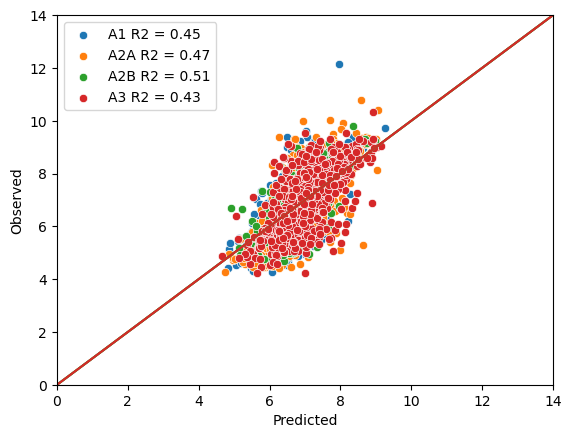

In [32]:
# Train and validate PCM model
train_validate_pcm_model(adenosine_receptors, train_random, test_random)

Based on the performance metrics of the PCM model, Pearson's $r$ tells us that the true and predicted values are highly correlated. Moreover, the $R^{2}$ tells us that almost 50 % of the variance of the target variable is explained by the model features and that the model is predictive. The $MAE$ tells us that the predictions are on average 0.64 p-value units off, which is an acceptable prediction error.
An interesting observation is that the $R^{2}$ score is quite similar if we calculate it independently for the test set datapoint corresponding to each target.

##### Random split QSAR models

Now, we want to compare the use of a single PCM model for four targets vs. four independent QSAR models trained for each target solely on chemical compound features.

=== QSAR model performance A1 ===
{
    "Pearson r": 0.5986860794442124,
    "R2 score": 0.35708264748315865,
    "MAE": 0.5975955476925413
}
=== QSAR model performance A2A ===
{
    "Pearson r": 0.6331428179843668,
    "R2 score": 0.3984324237653284,
    "MAE": 0.6998201581163358
}
=== QSAR model performance A2B ===
{
    "Pearson r": 0.7006823641193349,
    "R2 score": 0.4803217299541849,
    "MAE": 0.5573997234421912
}
=== QSAR model performance A3 ===
{
    "Pearson r": 0.6643990005833391,
    "R2 score": 0.43854963831859717,
    "MAE": 0.6908388511158647
}


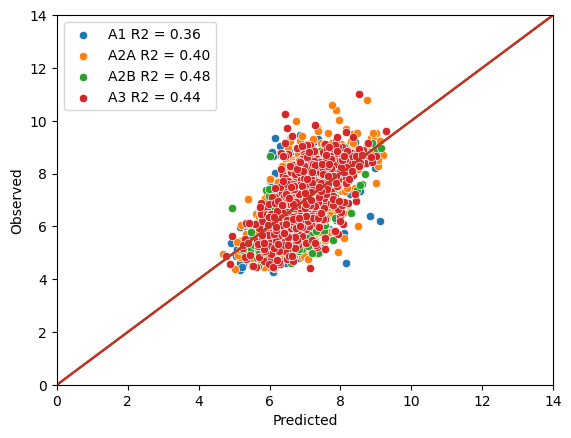

In [33]:
# Iterate over targets (adenosine receptors)
for target, accession in adenosine_receptors.items():
    # Train and validate QSAR models
    train_validate_qsar_model(ar_qsar_dataset, target, accession, 0.20)

The four QSAR models trained have quite good performance, with high correlation between the observed and predicted values. Compared to the PCM model, the $R^{2}$ score is less homogeneous between targets and, in general, lower. These results seem to indicate that the PCM model is able to extrapolate certain properties between targets.

##### Leave one target out split PCM model

The random split PCM model works pretty well. However, a model trained and validated on a random split might overestimate the performance compared to a real life drug discovery scenario since some compounds can be tested in several targets.
Finally, to test whether our PCM model could be used to predict bioactivity data on a target for which we have no previously known bioactivity data, we can train and validate PCM models following the "leave one target out" (LOTO) split method. We can do this process for each of the adenosine receptors.

== Leave one target out split ==
Target left out for testing is A1
Training set has 9200 datapoints
Test set has 3519 datapoints (27.667 %)
=== PCM model performance ===
{
    "Pearson r": 0.2577150000359349,
    "R2 score": -0.09531568827653203,
    "MAE": 0.8537743338477594
}
Not plotting A2A. Performance can only be plotted for the left out target in LOTO split
Not plotting A2B. Performance can only be plotted for the left out target in LOTO split
Not plotting A3. Performance can only be plotted for the left out target in LOTO split
== Leave one target out split ==
Target left out for testing is A2A
Training set has 8728 datapoints
Test set has 3991 datapoints (31.378 %)
=== PCM model performance ===
{
    "Pearson r": 0.21008560538267065,
    "R2 score": -0.042261684276110545,
    "MAE": 0.9620344947955969
}
Not plotting A1. Performance can only be plotted for the left out target in LOTO split
Not plotting A2B. Performance can only be plotted for the left out target in LOTO split
N

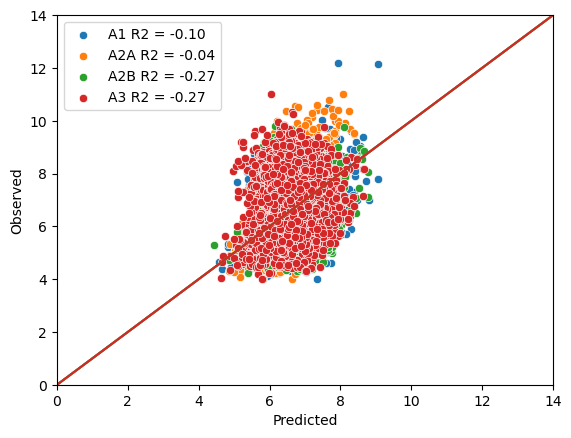

In [34]:
# Iterate over targets (adenosine receptors)
for target, accession in adenosine_receptors.items():
    # Split dataset in training and test set (leave one target out split)
    print("== Leave one target out split ==")
    train_loto, test_loto = split_train_test(ar_pcm_dataset, 0.20, "loto", target, accession)
    # Train and validate PCM model, every time leaving a different target out for validation
    train_validate_pcm_model(adenosine_receptors, train_loto, test_loto)

Immediately we see that the LOTO split method is way more difficult to model than the random split. The PCM metrics show that even though the true and predicted values are somewhat correlated (Pearson's $r$), the PCM model features are not able to explain the variance in the target variable ($R^{2}$). We can also see this in the shape of the predicted vs. observed graph, where the datapoints are not aggregated around the unit line that would define a perfect fit. Rather, the predictions are aggregated around the mean bioactivity values in the training set.

## Discussion

In this talktorial we created a PCM model for the four adenosine receptors based on a random split of the data. This model performed pretty well on our test set. Compared to independent QSAR models trained for each of the adenosine receptors, the performance of the PCM model is slightly better, which indicates that the PCM model is able to extrapolate between targets. However, there are several elements that could have an effect of the observed results:

* The four adenosine receptors had enough data on their own to be able to train individual models. The true advantage of a PCM model could be more relevant in a target set where some targets have very little data.
* The QSAR models are only trained on 22 features compared to 1,300 for the PCM model. QSAR models trained on molecular fingerprints would probably have better chances of achieving better performance.
* For better comparison, it would be good to train several models of the same type and calculate aggregated metrics, so that statistically significant results could be derived.

Moreover, we trained four PCM models on three adenosine receptors and validated them on the remaining receptor, following a leave one target out (LOTO) split method. We did this to evaluate whether these PCM models could be used to predict bioactivity for a target for which the model has never seen any data in training. We immediately derive some observations:

* The LOTO split is a more challenging form of validation than the random split, since the random split allows data leakage between targets.
* While the descriptors used in the PCM model trained on random split allowed for a good performance, in order to get a good performance in the LOTO split, we would need to search more carefully to find the optimal descriptors. Similarly, we could opt for a selection of the binding pocket prior to protein descriptor generation. Additionally, we could optimize the model parameters.


## Quiz

1. What types of features are needed for PCM?
2. What types of training/test set splitting methods commonly used in PCM modeling do you know?
3. Which applications do you know of PCM in drug discovery?